In [192]:
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from dateutil import parser
import datetime
plt.style.use('fivethirtyeight')
from datetime import datetime
from geopy.geocoders import Nominatim
geolocator = Nominatim(country_bias="US")
import scipy.stats
import pickle

###Lat/Lon

In [139]:
#load unique cities csv
df_cities = pd.read_csv("4945_count_sightings_correct_dates_correct_percap.csv",index_col=0)
#del df_cities['Unnamed: 0']
df_cities['dist_comp'] = pd.Series()
del df_cities['sqrt_airport']
del df_cities['sqrt_base']
del df_cities['sqrt_per_capita']
del df_cities['cubert_per_capita']
del df_cities['log_airport']
del df_cities['log_base']
del df_cities['log_per_capita']

In [140]:
#load full csv
full_df = pd.read_csv("52150_locations_USA_census_nonull.csv")
del full_df['Unnamed: 0']

In [141]:
subset = df_cities[['lat', 'lon']] #my lat/long

t = time.time() #timing

d = pairwise_distances(subset) #find pairwise distances between (lat,lon)
print("Shape",d.shape)

d_bool = d < .25 #close obs are less than .35 away from each other, assign true if so

g = nx.from_numpy_matrix(d_bool) #make my components ???

print("Number of comps",nx.number_connected_components(g))

print
print("Runtime",time.time()-t)
print

comps = [_ for _ in nx.connected_components(g)]
length_of_comps = [len(_) for _ in comps]
length_of_comps = pd.Series(length_of_comps)

('Shape', (4945, 4945))
('Number of comps', 1414)

('Runtime', 1.5108799934387207)



In [142]:
#example component
for ind in comps[90]:
    print df_cities.ix[ind].CityST

Alamogordo, NM
Tularosa, NM


In [143]:
#assign comp number to obs row of df
for i in range(len(length_of_comps)):
    for ind in comps[i]:
        df_cities.set_value(ind,9,i,takeable = True)

In [144]:
#write to csv
df_cities.to_csv("./data/4945_dist_comp_closer.csv",encoding="utf-8")

In [145]:
#merge with full dataset
merged = pd.merge(full_df,df_cities[['CityST','dist_comp']],how='inner',on='CityST')

###Date field to seconds

In [146]:
#find seconds since 1900 (arbitrary date)
def to_seconds(x):
    t = datetime.datetime(1900,1,1)
    return (parser.parse(x) - t).total_seconds()

In [147]:
#chose seconds over toordinal function because it includes time down to seconds, not just day
merged['seconds'] = merged['date_datetime'].map(lambda x: to_seconds(x)) 

###Bin seconds field

In [148]:
labels = range(100)

#bin distance to Airport and Military bases
bins_airport = pd.cut(full_df.AirportDist,100,labels=labels)
bins_military = pd.cut(full_df.BaseDist,100,labels=labels)

In [149]:
#use pandas function cut to bin seconds
num_bins = 30000
labels_seconds = range(num_bins)
bins_seconds = pd.cut(merged.seconds,num_bins, labels=labels_seconds)

In [150]:
#add bins as column to df
merged['bin_seconds'] = bins_seconds

In [151]:
merged.head()

,city,shape,duration,state,link,date,date_datetime,duration_seconds,day,link_no_ext,...,Name_2010,County,LAT,LON,year,pop,yr_of_sighting,dist_comp,seconds,bin_seconds
0,Mokena,circle,30 seconds,IL,121/S121083.html,8/13/15 21:00,2015-08-13 21:00:00,30,3,121/S121083,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2015,66,3648488400,29999
1,Mokena,cigar,1-3 minutes,IL,108/S108589.html,4/12/14 21:35,2014-04-12 21:35:00,180,5,108/S108589,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2014,66,3606327300,29500
2,Mokena,unknown,15-20 minutes,IL,102/S102620.html,9/24/13 19:45,2013-09-24 19:45:00,1200,1,102/S102620,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2013,66,3589040700,29295
3,Mokena,circle,15-20 minutes,IL,089/S89213.html,5/26/12 21:00,2012-05-26 21:00:00,1200,5,089/S89213,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2012,66,3547054800,28797
4,Mokena,light,20 sec,IL,083/S83822.html,9/9/11 23:05,2011-09-09 23:05:00,20,4,083/S83822,...,Mokena village,Will,41.529863,-87.87771,2010,18740,2011,66,3524598300,28531


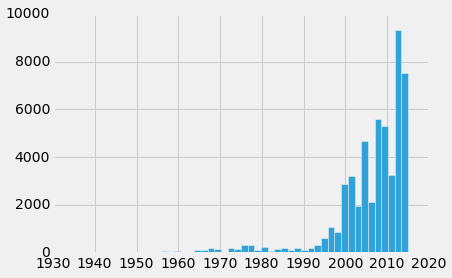

In [152]:
#see distribution of years
merged.yr_of_sighting.hist(bins=50)

###Aggregate

In [153]:
merged['bin_seconds'] = merged['bin_seconds'].astype(int) #convert bin_seconds from categorical var

In [154]:
agg = merged.groupby(['bin_seconds','dist_comp']) #groupby time bin and location bin

In [156]:
counts = pd.DataFrame(agg.size()).reset_index()
counts=counts.rename(columns = {0:'counts'})

In [157]:
counts = counts.reset_index()

In [158]:
counts.head()

,index,bin_seconds,dist_comp,counts
0,0,0,141,1
1,1,847,141,1
2,2,1554,732,1
3,3,1893,575,1
4,4,2541,141,1


###Merge this

In [25]:
print len(merged)
print len(counts)

52150
45174


In [159]:
#have each sighting be attributed to "counts" value, or number of sightings in its cluster
new_merged = pd.merge(merged,counts,how="inner",on=['bin_seconds','dist_comp'])

In [160]:
new_merged.head()

,city,shape,duration,state,link,date,date_datetime,duration_seconds,day,link_no_ext,...,LAT,LON,year,pop,yr_of_sighting,dist_comp,seconds,bin_seconds,index,counts
0,Mokena,circle,30 seconds,IL,121/S121083.html,8/13/15 21:00,2015-08-13 21:00:00,30,3,121/S121083,...,41.529863,-87.87771,2010,18740,2015,66,3648488400,29999,45172,1
1,Mokena,cigar,1-3 minutes,IL,108/S108589.html,4/12/14 21:35,2014-04-12 21:35:00,180,5,108/S108589,...,41.529863,-87.87771,2010,18740,2014,66,3606327300,29500,40003,1
2,Mokena,unknown,15-20 minutes,IL,102/S102620.html,9/24/13 19:45,2013-09-24 19:45:00,1200,1,102/S102620,...,41.529863,-87.87771,2010,18740,2013,66,3589040700,29295,37703,1
3,Mokena,circle,15-20 minutes,IL,089/S89213.html,5/26/12 21:00,2012-05-26 21:00:00,1200,5,089/S89213,...,41.529863,-87.87771,2010,18740,2012,66,3547054800,28797,32479,1
4,Mokena,light,20 sec,IL,083/S83822.html,9/9/11 23:05,2011-09-09 23:05:00,20,4,083/S83822,...,41.529863,-87.87771,2010,18740,2011,66,3524598300,28531,30218,2


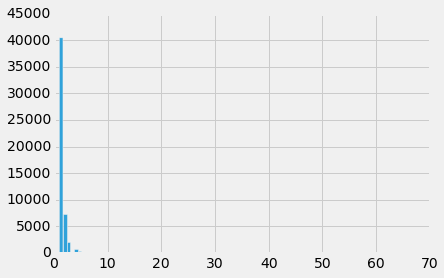

In [161]:
new_merged.counts.hist(bins=100)

In [29]:
#write to csv
new_merged.to_csv("./data/52150_reliability_count_closer_index.csv",encoding="utf-8")

##Matching new sightings with similar data (time & location)

In [ ]:
#try KNN
results = []
for n in range(1,21):
    k = KNeighborsClassifier(n_neighbors=n)
    k.fit(X_train,y_train)
    results.append(accuracy_score(k.predict(X_test),y_test))
    print("Accuracy at k={0}: {1:0.4f}".format(n,accuracy_score(k.predict(X_test),y_test)))

k_best = results.index(max(results))+1
print("\nMax accuracy score of {0:0.4f} with k-value {1}".format(max(results),duplicates(results,max(results))))

In [405]:
location = "sdfdfs"
def check_location(location = location):
    try:
        geo = geolocator.geocode(location, timeout=60).raw
        return location
    except:
        return check_location(location = "Austin, TX")

In [406]:
check_location("asdsad")

'Austin, TX'

In [187]:
def date_to_seconds(x):
    date_object = datetime.strptime(x, '%m/%d/%Y %H:%M')
    seconds = to_seconds(date_object)
    return seconds

def to_seconds(x):
    t = datetime(1900,1,1)
    try:
        return (parser.parse(x) - t).total_seconds()
    except:
        return (x-t).total_seconds()

def to_ordinal(x):
    return parser.parse(x).toordinal()

def location_to_comp(x):
    from geopy.geocoders import Nominatim
    geolocator = Nominatim()
    
    cities = pd.read_csv("4945_dist_comp_closer.csv")    
    
    if x in cities.CityST.values: #if location already in df. change this to hash lookup
        lat = cities[cities['CityST']==x].lat.values[0]
        lon = cities[cities['CityST']==x].lon.values[0]
    else:
        lat = geolocator.geocode(x).latitude
        lon = geolocator.geocode(x).longitude
    
    d = pairwise_distances(df_cities[['lon','lat']],(lon,lat))
    
    return df_cities.ix[np.argsort(d,axis=None)[0]]['dist_comp']

In [184]:
#find distance comp of location or nearest location in df
location_to_comp("austin, tx")

64.0

In [190]:
#return link ids for nearest sightings
select_date = "04/11/2014 8:00"
select_location = "Seattle, WA"

def test(time = 45000):
    subset_time = merged[abs(merged['seconds']-date_to_seconds(select_date))<time] #45000 within 12 hours
    subset_timedist = subset_time[subset_time['dist_comp']==
                                  int(location_to_comp(select_location))]
    test_links = subset_timedist.link_no_ext.values
    
    if len(test_links)>0:
        return test_links
    
    else:
        print time
        time += 100000
        return test(time)

In [191]:
test_links = test()
test_links

array(['108/S108583', '108/S108538'], dtype=object)

In [378]:
#pickle results
with open("test_links.pkl",'wb') as pf:
    pickle.dump(test_links,pf)

##Compare distributions of "reliable" and "unreliable" sightings

In [164]:
df = pd.read_csv("./data/52150_reliability_count_closer_index.csv")
del df['Unnamed: 0']
df['time'] = df['date_datetime'].map(lambda x: parser.parse(x).time().hour)

In [165]:
def time_of_day(x):
    if x >= 21 or x < 5:
        return "night"
    elif x >= 5 and x < 12:
        return "morning"
    else:
        return "afternoon"
    
df['time_of_day'] = df['time'].map(lambda x: time_of_day(x))

In [166]:
reliables = df[df['counts']>=3].reset_index()
unreliables = df[df['counts']==1].reset_index()

In [167]:
reliables['shape'].value_counts().sum()

4429

In [113]:
print scipy.stats.ttest_ind(np.array(reliables.AirportDist),np.array(unreliables.AirportDist),equal_var = False)
print scipy.stats.ttest_ind(np.array(reliables.BaseDist),np.array(unreliables.BaseDist),equal_var = False)
print scipy.stats.ttest_ind(np.array(reliables['pop']),np.array(unreliables['pop']),equal_var = False)
print scipy.stats.ttest_ind(np.array(reliables['duration_seconds']),np.array(unreliables['duration_seconds']),equal_var = False)
print scipy.stats.ttest_ind(np.array(reliables['seconds']),np.array(unreliables['seconds']),equal_var = False)

(-29.386639111568154, 2.0863364568326756e-180)
(-27.941343898789832, 2.4442942760532803e-164)
(7.6628331885942069, 2.1844749217248073e-14)
(0.22823072843646897, 0.81947629404819466)
(33.055524510921487, 3.8791001666283194e-224)


In [169]:
#compare various metrics between reliable and unreliable
dfs = {"reliable":reliables, "unreliable":unreliables}
for name,df in dfs.iteritems():
    print name
    print "airport",df.AirportDist.describe()['mean']
    print "base",df.BaseDist.describe()['mean']
    print "pop",df['pop'].describe()['mean']
    print "night",float(df.time_of_day.value_counts()['night'])/df.time_of_day.value_counts().sum()
    print "morning",float(df.time_of_day.value_counts()['morning'])/df.time_of_day.value_counts().sum()
    print "afternoon",float(df.time_of_day.value_counts()['afternoon'])/df.time_of_day.value_counts().sum()
    print

unreliable
airport 15.3046670623
base 48.9231492655
pop 170521.372341
night 0.54579822589
morning 0.103012033308
afternoon 0.351189740802

reliable
airport 10.6140468635
base 35.4195240347
pop 243112.45315
night 0.608037931813
morning 0.0593813501919
afternoon 0.332580717995



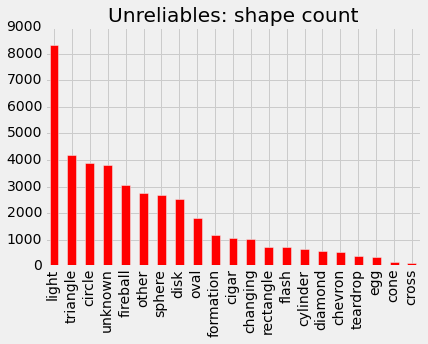

In [170]:
unreliables['shape'].value_counts().plot(kind="bar", color='r')
plt.title("Unreliables: shape count")

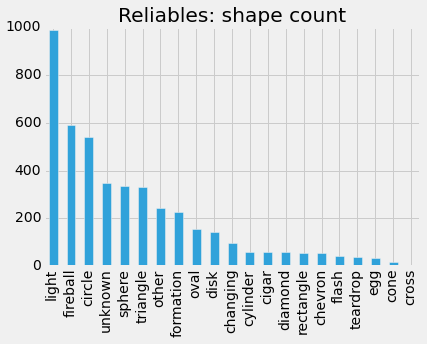

In [63]:
reliables['shape'].value_counts().plot(kind="bar")
plt.title("Reliables: shape count")

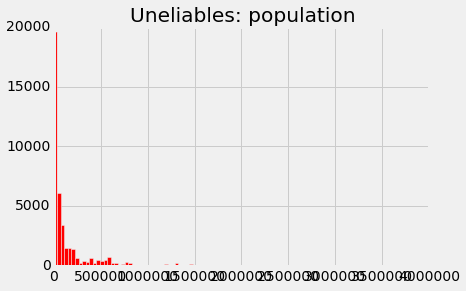

In [171]:
unreliables['pop'].hist(bins=100, color='r')
plt.title("Uneliables: population")

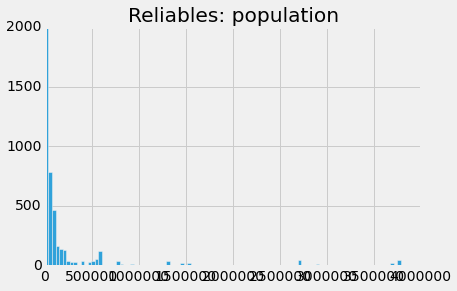

In [172]:
reliables['pop'].hist(bins=100)
plt.title("Reliables: population")

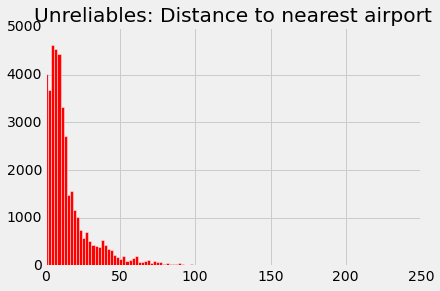

In [173]:
unreliables.AirportDist.hist(bins=100, color='r')
plt.title("Unreliables: Distance to nearest airport")

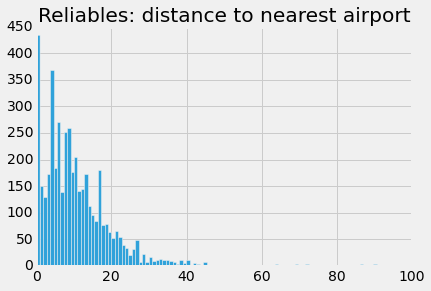

In [174]:
reliables.AirportDist.hist(bins=100)
plt.title("Reliables: distance to nearest airport")

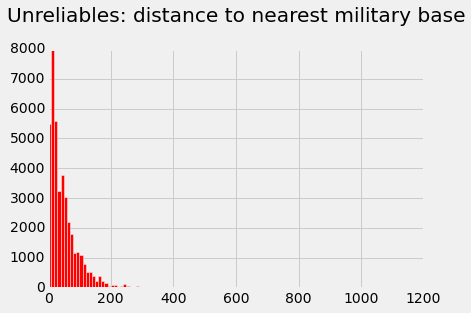

In [176]:
unreliables.BaseDist.hist(bins=100, color='r')
plt.title("Unreliables: distance to nearest military base\n")

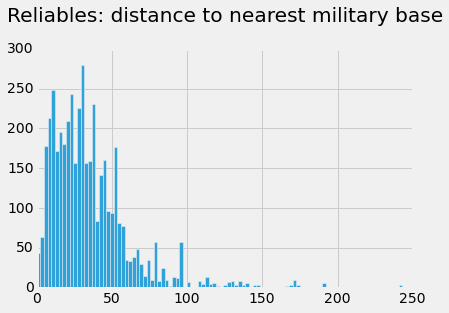

In [177]:
reliables.BaseDist.hist(bins=100)
plt.title("Reliables: distance to nearest military base\n")

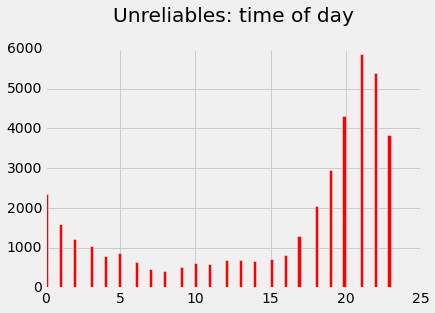

In [178]:
unreliables.time.hist(bins=100, color = 'r')
plt.title("Unreliables: time of day\n")

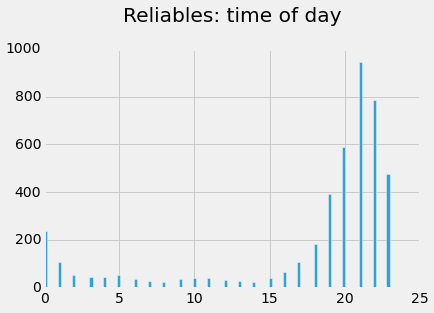

In [179]:
reliables.time.hist(bins=100)
plt.title("Reliables: time of day\n")